# Exploratory Time Series Analysis

In [1]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import date, datetime, timedelta

In [2]:
sns.set_style('whitegrid')

## Overview

In this notebook, we fit a polynomial model on the trend of the monthly average bike usage based on the training data and store the result in a seperate csv file called 'residue_of_trend.csv'

A quick look at the result and data explanation:
1. The column 'trend_poly' represents the predicted value of trend (by polynomial model) at a monthly basis. Since we used 2017 as a base year, 'trend_poly' = 0 for year 2017.
2. The column 'num_trips_residue' was calculated by removing 'trend_poly' from the monthly average bike trips. A plot of 'num_trips_residue' versus time is below:
3. If you want to use this result to remove the trend from daily data while doing your own EDA, you can just substract 'trend_poly' from the 'num_trips' of that day. For example, bike trips on 2018-02-10 without trend will be: 'num_trips' of 2018-02-10 minus 'trend_poly' of 2018-02.

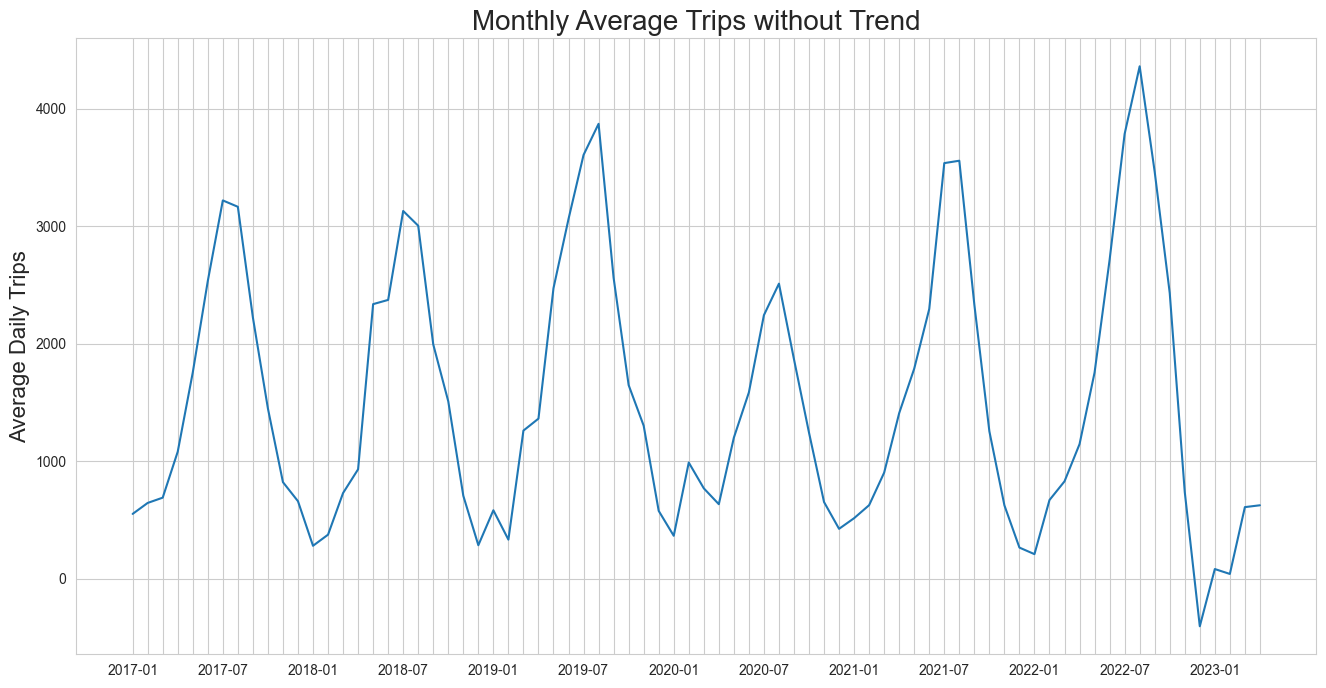

In [3]:
result = pd.read_csv("time_series_residue.csv")
result.set_index('Year-Month', inplace=True)

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(8)
fig.set_figwidth(16)

sns.lineplot(x=np.arange(len(result)), y=result['num_trips_residue'])

ax.set_xticks(np.arange(len(result)))
# ax.xaxis.set_major_locator(ticker.MultipleLocator(6))
ax.set_xticklabels(result.index)
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 6 == 0:  # every 6th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
        
plt.ylabel('Average Daily Trips',fontsize=16)
plt.title('Monthly Average Trips without Trend', fontsize=20)
plt.show()

## Import Data

In [4]:
bike_train = pd.read_csv('bikeshare_train_data.csv')
bike_test = pd.read_csv('bikeshare_test_data.csv')

In [5]:
bike_train.head()

,Date,day_length,min_temp,max_temp,mean_temp,temp_diff,hdd,cdd,rain,snow,total_precip,snow_on_ground,max_gust,mean_dep_temp,mean_ret_temp,mean_ride_temp,total_dist,total_duration,ebike_trips,num_trips
0,2017-01-01,497.133333,-2.3,2.2,-0.1,4.5,18.1,0.0,0.0,0.0,0.0,3.0,10.0,3.555556,4.296296,3.925926,338025.0,232693.0,0.0,162
1,2017-01-02,498.133333,-6.0,1.4,-2.3,7.4,20.3,0.0,0.0,0.0,0.0,2.0,0.0,2.718519,3.688889,3.203704,660054.0,382729.0,0.0,270
2,2017-01-03,499.133333,-7.8,0.4,-3.7,8.2,21.7,0.0,0.0,0.0,0.0,1.0,0.0,0.807292,1.791667,1.299479,635395.0,376013.0,0.0,384
3,2017-01-04,501.133333,-8.4,2.2,-3.1,10.6,21.1,0.0,0.0,0.0,0.0,1.0,1.0,2.767391,3.643478,3.205435,766082.0,376721.0,0.0,460
4,2017-01-05,502.133333,-6.6,0.7,-3.0,7.3,21.0,0.0,0.0,0.0,0.0,1.0,0.0,2.601145,3.524809,3.062977,888222.0,524933.0,0.0,524


In [6]:
bike_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2311 entries, 0 to 2310
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            2311 non-null   object 
 1   day_length      2311 non-null   float64
 2   min_temp        2311 non-null   float64
 3   max_temp        2311 non-null   float64
 4   mean_temp       2311 non-null   float64
 5   temp_diff       2311 non-null   float64
 6   hdd             2311 non-null   float64
 7   cdd             2311 non-null   float64
 8   rain            2311 non-null   float64
 9   snow            2311 non-null   float64
 10  total_precip    2311 non-null   float64
 11  snow_on_ground  2311 non-null   float64
 12  max_gust        2311 non-null   float64
 13  mean_dep_temp   2311 non-null   float64
 14  mean_ret_temp   2311 non-null   float64
 15  mean_ride_temp  2311 non-null   float64
 16  total_dist      2311 non-null   float64
 17  total_duration  2311 non-null   f

In [7]:
#split the date into the following columns: Year-Month, Year, Month, Day
def get_year(date_str):
    return(date_str.split('-')[0])
def get_month(date_str):
    return(date_str.split('-')[1])
def get_day(date_str):
    return(date_str.split('-')[2])
def get_year_month(date_str):
    return ('-'.join((date_str.split('-')[0],date_str.split('-')[1])))

In [8]:
bike_train['Year-Month'] = bike_train['Date'].apply(get_year_month)
bike_train['Year'] = bike_train['Date'].apply(get_year)
bike_train['Month'] = bike_train['Date'].apply(get_month)
bike_train['Day'] = bike_train['Date'].apply(get_day)

bike_test['Year-Month'] = bike_test['Date'].apply(get_year_month)
bike_test['Year'] = bike_test['Date'].apply(get_year)
bike_test['Month'] = bike_test['Date'].apply(get_month)
bike_test['Day'] = bike_test['Date'].apply(get_day)

In [9]:
def str_to_date(s):
    return (datetime.strptime(s,'%Y-%m'))

## Modeling the Trend

### Differencing in Years:

We first average the daily bike trips where the average is taken over each month. The result is stored in dataframe "monthly_mean".

In [10]:
monthly_mean = bike_train.groupby('Year-Month')['num_trips'].mean().to_frame()

Then we will use 2017 as a base year, and substract the monthly average of 2017 num_trips from the corresponding monthly mean of later years. This way we remove seasonality but preserve the yearly trend in our residue. We store the difference in the dataframe "monthly_diff".

In [11]:
monthly_diff = monthly_mean.iloc[12:].copy()

In [12]:
for i,k in enumerate(monthly_diff.index):
    monthly_diff.iloc[i] = monthly_diff.iloc[i] - monthly_mean.iloc[i%12]

In [13]:
# Add a numerical version of date for regression purpose
monthly_diff['time'] = 0

In [14]:
for i, index in enumerate(monthly_diff.index):
    monthly_diff.loc[index,'time'] = i

### Plot of the Trend

We will plot the data stored in "monthly_diff". Note that this represents trend without seasonality.

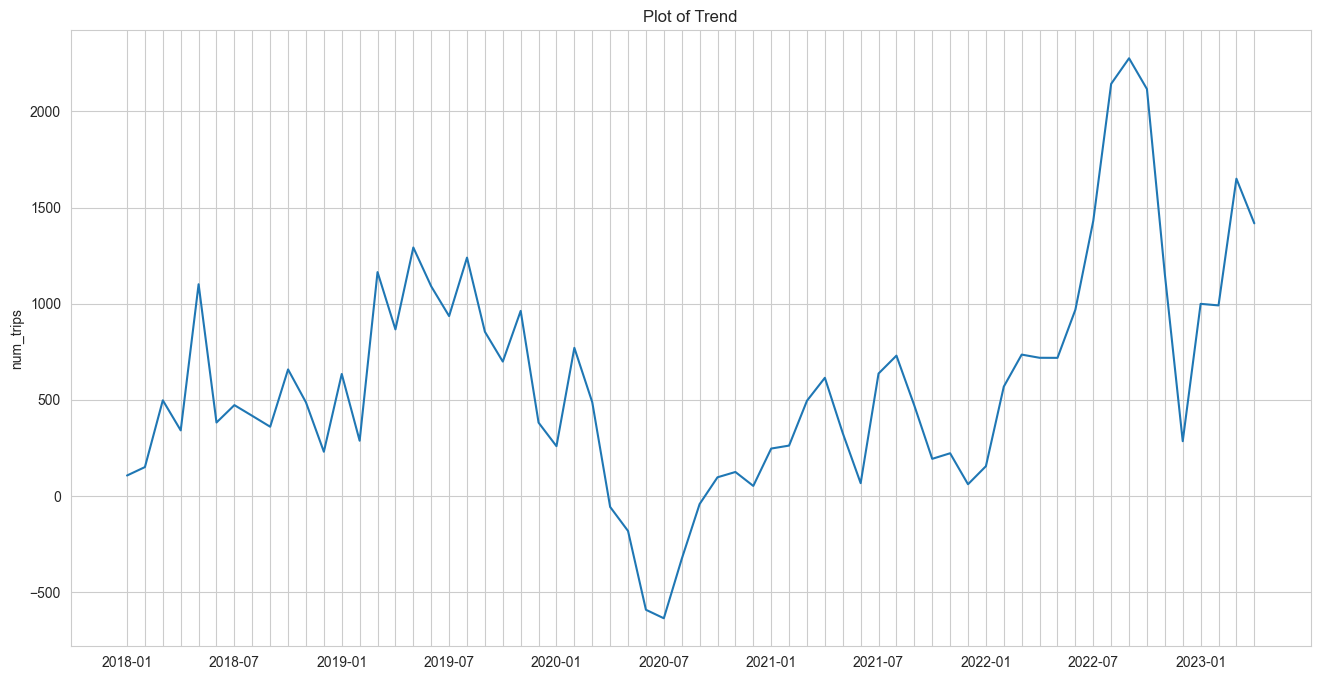

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(8)
fig.set_figwidth(16)

sns.lineplot(x=np.arange(len(monthly_diff)), y=monthly_diff['num_trips'])
ax.set_xticks(np.arange(len(monthly_diff)))
# ax.xaxis.set_major_locator(ticker.MultipleLocator(6))
ax.set_xticklabels(monthly_diff.index)
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 6 == 0:  # every 6th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
        
plt.title('Plot of Trend')
plt.show()

### Polynomial Model with degree 3 to 6

As a baseline model, we will do a polynomial regression.

In [16]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

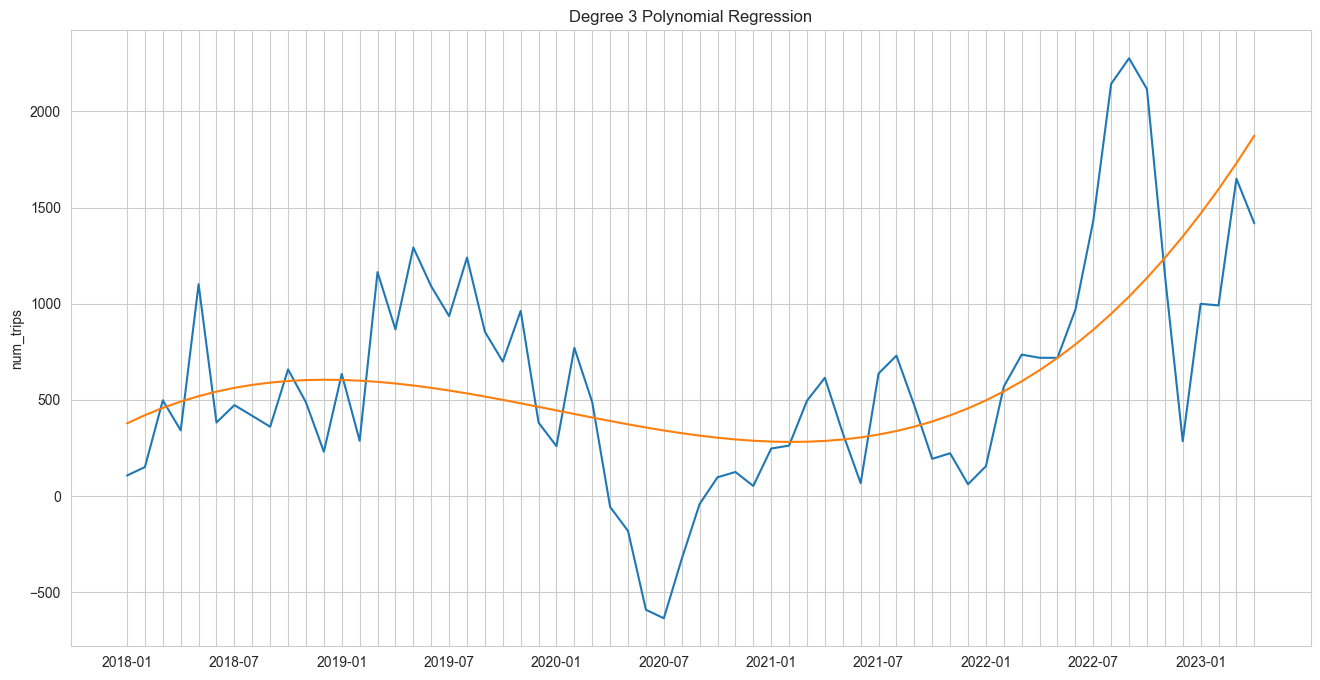

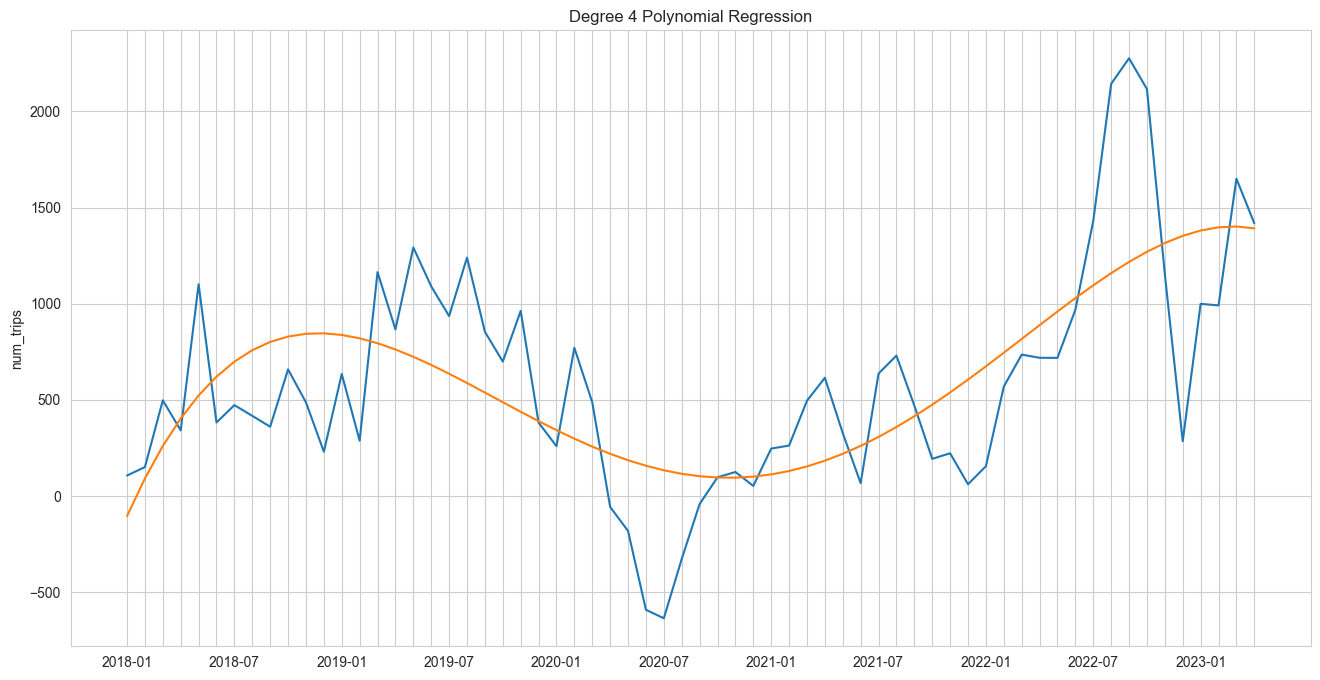

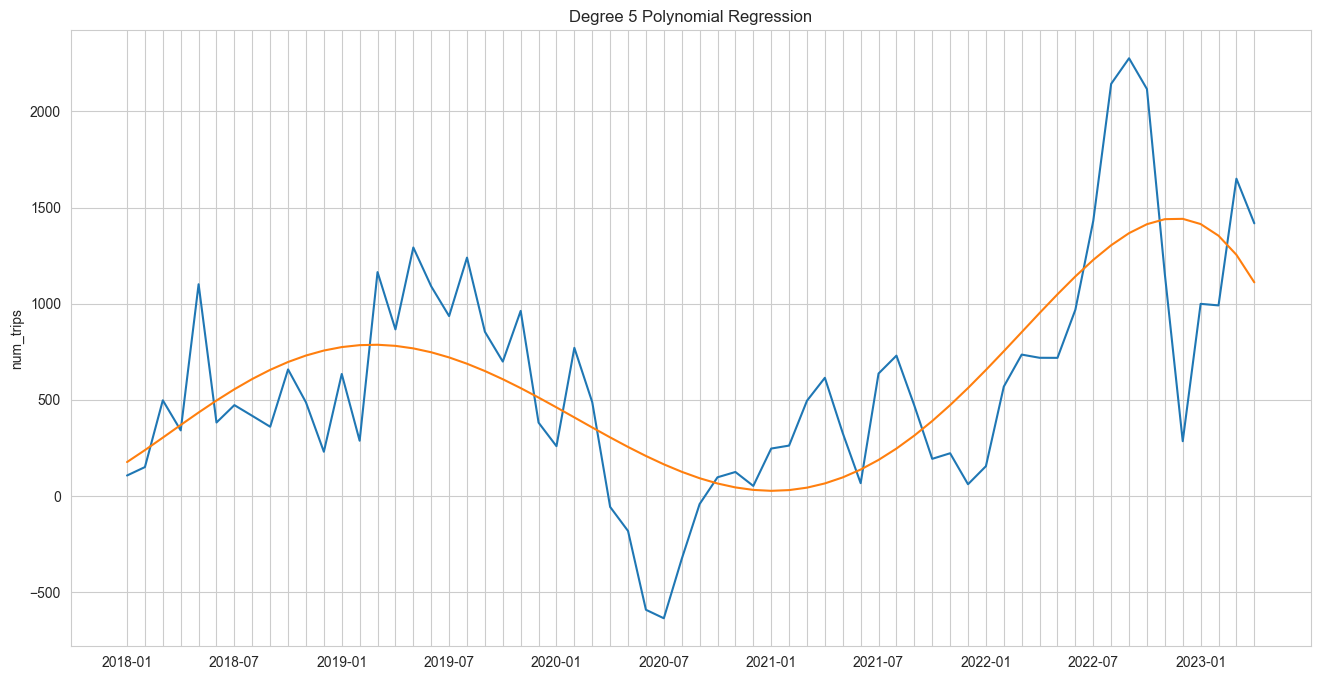

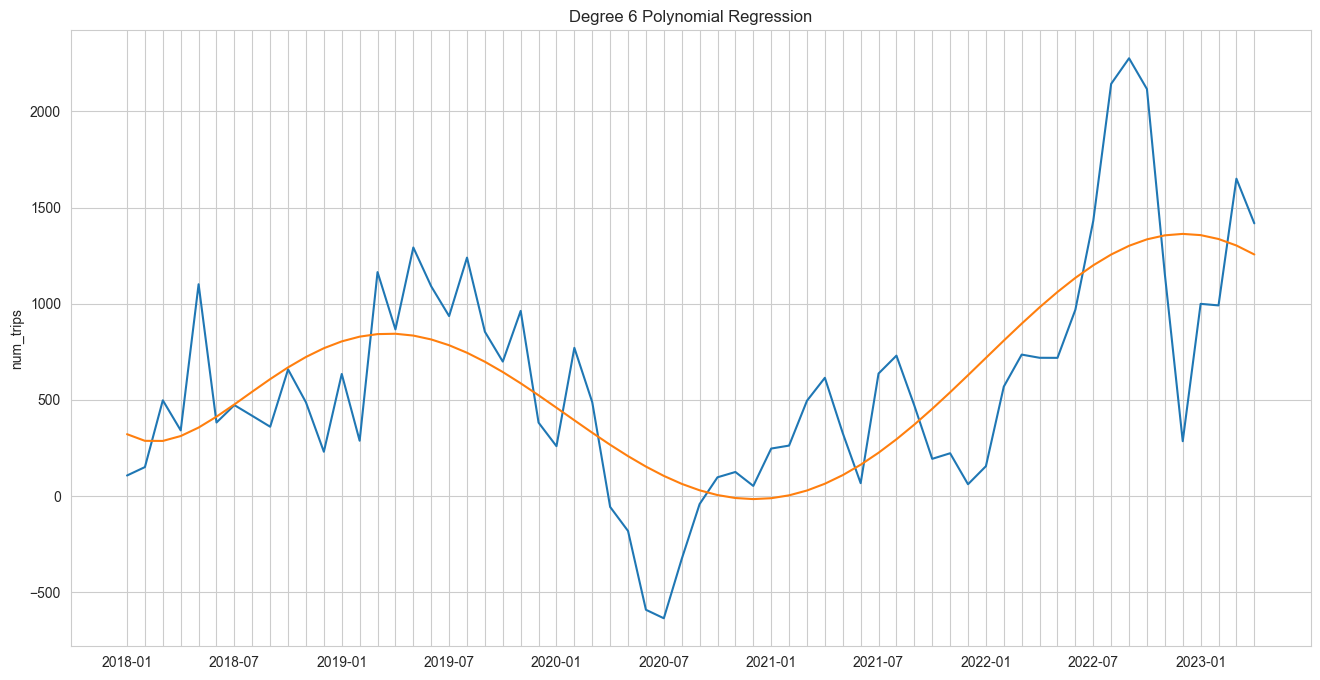

In [17]:
for k in range(3,7):
# k is degree of the polynomial 
    poly = PolynomialFeatures(k)
    reg = LinearRegression()
    reg.fit(poly.fit_transform(monthly_diff[['time']]), monthly_diff['num_trips'])
    pred = reg.predict(poly.fit_transform(monthly_diff[['time']]))
    
    #Store the trend model in monthly_diff['k_deg_trend']
    monthly_diff[f'{k}_deg_trend'] = pred
    
    
    #Plot the k degree regression plot
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_figheight(8)
    fig.set_figwidth(16)

    sns.lineplot(x=np.arange(len(monthly_diff)), y=monthly_diff['num_trips'])
    sns.lineplot(x=np.arange(len(monthly_diff)), y=pred)

    ax.set_xticks(np.arange(len(monthly_diff)))
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(6))
    ax.set_xticklabels(monthly_diff.index)
    for ind, label in enumerate(ax.get_xticklabels()):
        if ind % 6 == 0:  # every 6th label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)
        
    plt.title(f'Degree {k} Polynomial Regression')
    plt.show()



It is important to note that we used polynomial model solely to "compensate" the sudden decrease in 2020, so that we can use the 2020 data for training purpose. (The actual trend looks more like linear outside 2020.) Thus, it is dangerous to pick high degree polynomial model due to the risk of overfitting. (Notice how the degree 5 polynomial already starts to decrease at the end of x-axis, which is caused by overfitting of the last few data points). 
**Based on the result, I think degree 3 is sufficient in modeling the trend while compensating the 2020 loss in the mean time.**

Now we look at the residue of num_trips from 2017 to 2023 after we remove the degree 3 polynomial model of trend from our original data. We will create a new column in "monthly_mean" called "poly_residue". Its value is equal to the original num_trips minus the trend(predicted by the polynomial model).

In [18]:
monthly_mean['num_trips'].astype('float')

Year-Month
2017-01     550.870968
2017-02     644.321429
2017-03     689.129032
2017-04    1080.333333
2017-05    1753.870968
              ...     
2022-12     944.225806
2023-01    1550.225806
2023-02    1635.571429
2023-03    2339.129032
2023-04    2498.233333
Name: num_trips, Length: 76, dtype: float64

In [19]:
monthly_mean['poly_residue'] = 0
for i in range(0,12):
    monthly_mean.iloc[i,1] = monthly_mean.iloc[i,0]

/var/folders/z_/vfnvng3n3hg_y07yr6f3l64w0000gn/T/ipykernel_9414/2642130854.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '550.8709677419355' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  monthly_mean.iloc[i,1] = monthly_mean.iloc[i,0]


In [20]:
for index in monthly_diff.index:
    monthly_mean.loc[index,'poly_residue'] = monthly_mean.loc[index,'num_trips'] - monthly_diff.loc[index,'3_deg_trend']

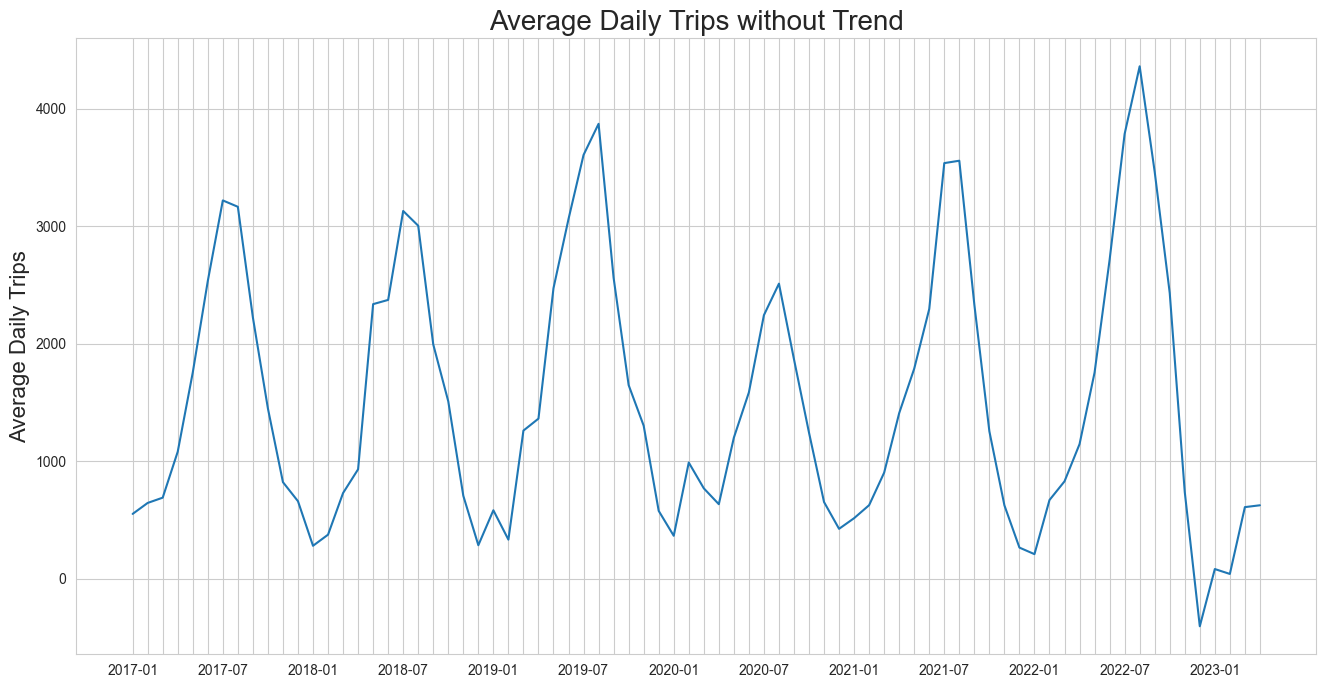

In [21]:
#Plot the 3 degree residue plot
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(8)
fig.set_figwidth(16)

sns.lineplot(x=np.arange(len(monthly_mean)), y=monthly_mean['poly_residue'])

ax.set_xticks(np.arange(len(monthly_mean)))
# ax.xaxis.set_major_locator(ticker.MultipleLocator(6))
ax.set_xticklabels(monthly_mean.index)
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 6 == 0:  # every 6th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
        
plt.ylabel('Average Daily Trips',fontsize=16)
plt.title('Average Daily Trips without Trend', fontsize=20)
plt.show()



The plot above shows the monthly average data after the polynomial model of trend is removed.

In [22]:
df = monthly_mean[['poly_residue']].copy()
df.columns = ['num_trips_residue']
df['trend_poly'] = monthly_mean['num_trips'] - df['num_trips_residue']
df = df.round(2)

In [23]:
df.to_csv('time_series_residue.csv')

It looks like there is still part of the trend that our low degree polynomial could not capture. 

### Piece-wise Linear Model

We might also try piecewise linear function to model the trend. Because the original plot looks more linear than polynomial if without the 2020 loss.

## Trigonometric Model for Seasonality

With the residue data free from trend, we might try a trigonometric regression to model seasonality and compare the result with the models based on weather data. 